# Chapter 8: Tree based methods

In [29]:
import pandas as pd
import random
import math
import operator
import numpy as np
import scipy as sc
from IPython.display import display, HTML, Image

In [402]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.externals.six import StringIO  
from sklearn import tree
from sklearn import preprocessing
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

# Resampling
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score

import pydotplus
import graphviz 

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
from matplotlib import gridspec

%matplotlib inline
plt.style.use('smandry')

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
def print_diagtest(y, y_pred):
    # diagnostic test
    precision, recall, fscore, support = precision_recall_fscore_support(y, y_pred)
    # Finding accuracy score
    accuracy = accuracy_score(y_pred, y)
    print('precision: {}'.format(precision[1]))
    print('recall   : {}'.format(recall[1]))
    print('fscore   : {}'.format(fscore[1]))
    print('support  : {}'.format(support[1]))
    print "accuracy : {}".format(accuracy)
    # Confusion matrix
    display(pd.crosstab(y_pred, y,rownames=['Predicted'], colnames=['True'], margins=True))

## Regression tree

In [319]:
Hitters = pd.read_csv('Data/Hitters.csv', index_col=0)
object_type = Hitters.columns[Hitters.dtypes == object].values
Hitters = pd.get_dummies(Hitters, columns=object_type, drop_first=True)
# Dropping NaN
Hitters.dropna(inplace=True)

In [71]:
regr = tree.DecisionTreeRegressor(max_leaf_nodes=3)
features = ['Hits', 'Years']
regr.fit(Hitters[features], np.log(Hitters['Salary'].values))
#for regr.feature_importances_

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=3, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [660]:
def visualize_tree(trees, feature_names=None, with_png=False, **kwarg):
    """Create tree using graphviz.
    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    dot_data = tree.export_graphviz(trees, out_file=None, feature_names=feature_names,**kwarg)
    if with_png:
        pydot_graph = pydotplus.graph_from_dot_data(dot_data)
        return pydot_graph
    else:
        return graphviz.Source(dot_data)

def feature_importance(model, features, relative=False):
    """Plot feature importance.
    Args
    ----
    tree -- scikit-learn DecsisionTree.
    features -- list of feature names.
    relative --importances relative to max importance  
    """
    feature_importance = model.feature_importances_
    # importances relative to max importance
    if relative:
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[::-1]
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure()
    plt.barh(pos, feature_importance[sorted_idx[::-1]], align='center')
    plt.yticks(pos, np.asarray(features)[sorted_idx[::-1]])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()    
    

In [661]:
#visualize_tree(regr, ['Years', 'Hits'], filled=True, rounded=True)

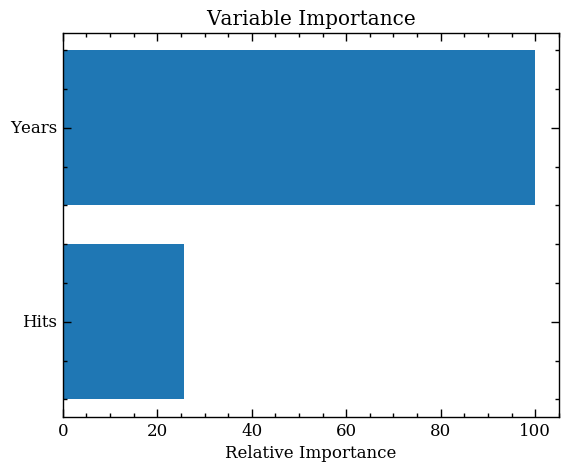

In [97]:
feature_importance(regr, features, relative=True)

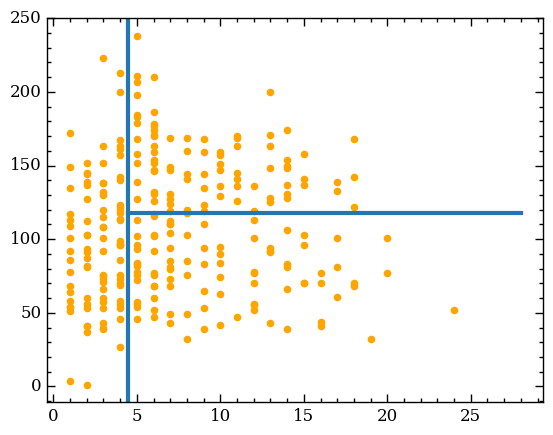

In [140]:
# Figure 8.2
fig, ax = plt.subplots()
ax.scatter('Years', 'Hits', data=Hitters, color='orange')
#feat = regr.tree_.feature
threshold = [x for x in regr.tree_.threshold if x!=-2]
ax.axvline(threshold[0], lw=3)
ax.plot([threshold[0],28],[threshold[1], threshold[1]], lw=3)
plt.show()

In [ ]:
regr = tree.DecisionTreeRegressor(max_leaf_nodes=3)
features = ['Hits', 'Years']
regr.fit(Hitters[features], np.log(Hitters['Salary'].values))

In [141]:
Hitters.columns

Index([u'Unnamed: 0', u'AtBat', u'Hits', u'HmRun', u'Runs', u'RBI', u'Walks',
       u'Years', u'CAtBat', u'CHits', u'CHmRun', u'CRuns', u'CRBI', u'CWalks',
       u'League', u'Division', u'PutOuts', u'Assists', u'Errors', u'Salary',
       u'NewLeague'],
      dtype='object')

In [270]:
Hitters.head(2)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0


In [273]:
#feats = ['Years', 'Hits','PutOuts', 'RBI', 'Runs', 'Walks']
col = Hitters.columns
feats = col[col != 'Salary'].values
regr = tree.DecisionTreeRegressor(max_features=9, min_samples_leaf=10)
regr.fit(Hitters[feats], np.log(Hitters['Salary'].values))


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=9,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [404]:
scaler = preprocessing.StandardScaler()
Hitters_scale = scaler.fit_transform(Hitters[feats])

### Regression with cross-validation

In [416]:
param_grid={'max_leaf_nodes':np.arange(2, 30)}
RegTree = tree.DecisionTreeRegressor(max_features=9, min_samples_leaf= 3)
regCV = GridSearchCV(RegTree, param_grid=param_grid, scoring='neg_mean_squared_error' , cv=10)
regCV.fit(Hitters_scale, np.log(Hitters['Salary'].values))

test_score = -regCV.cv_results_['mean_test_score']
train_score = -regCV.cv_results_['mean_train_score']
test_score_std = -regCV.cv_results_['std_test_score']
train_score_std = -regCV.cv_results_['std_train_score']


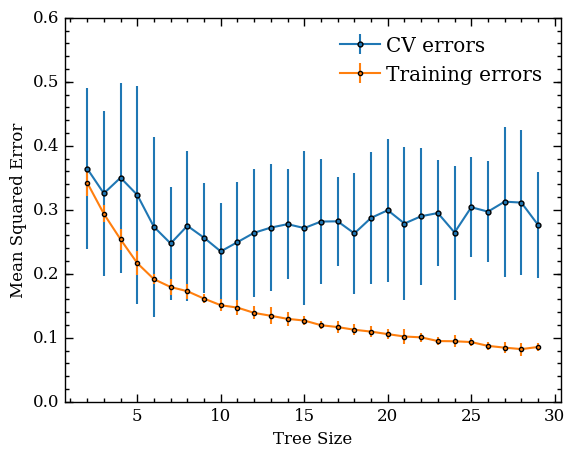

In [417]:
fig, ax = plt.subplots()
ax.errorbar(np.arange(2, 30), test_score, test_score_std, marker='o', ms=3.5, label='CV errors')
ax.errorbar(np.arange(2, 30), train_score, train_score_std, marker='o', ms=3, label='Training errors')
ax.set_ylim([0,0.6])
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Tree Size')
ax.legend()
plt.show()

In [418]:
regCV.best_params_

{'max_leaf_nodes': 10}

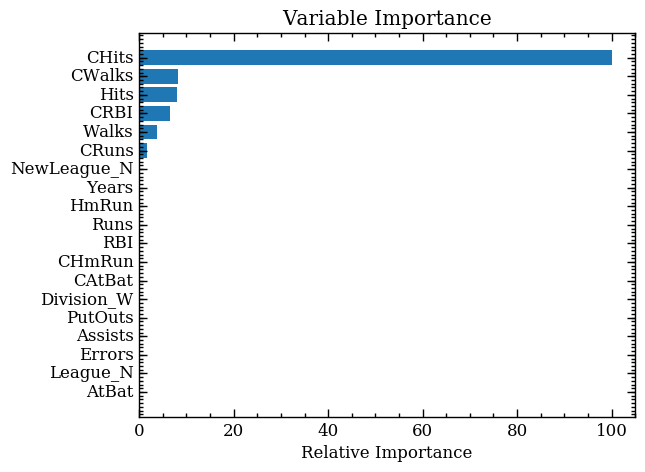

In [419]:
best_regCV = tree.DecisionTreeRegressor(max_features=9, max_leaf_nodes=10, min_samples_leaf= 2)
best_regCV.fit(Hitters_scale, np.log(Hitters['Salary'].values))
feature_importance(best_regCV, feats, relative=True)

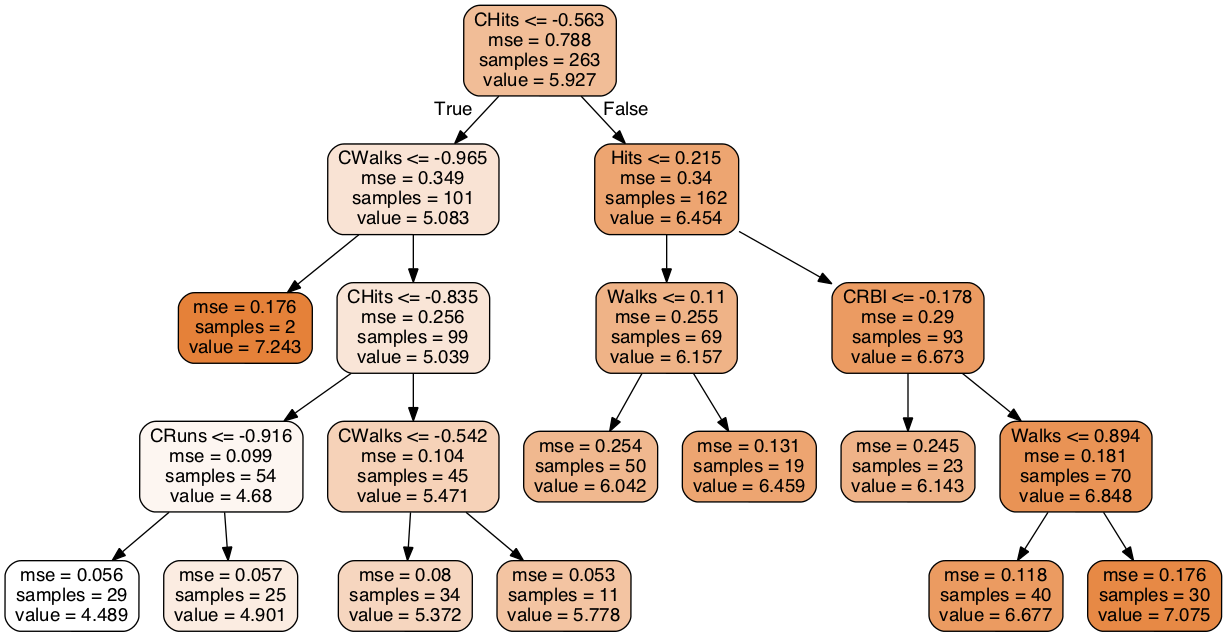

In [664]:
vis_tree = visualize_tree(best_regCV, with_png=True, feature_names=feats, filled=True, rounded=True)
Image(vis_tree.create_png())

## classification tree

In [441]:
Heart = pd.read_csv('Data/Heart.csv')
Heart.drop('Unnamed: 0',axis=1, inplace=True)
Heart.dropna(inplace=True)

In [231]:
Heart.ChestPain.unique()

array(['typical', 'asymptomatic', 'nonanginal', 'nontypical'], dtype=object)

In [442]:
Heart['AHD'] = Heart.AHD.map({'No':0, 'Yes':1})
object_type = Heart.columns[Heart.dtypes == object].values
Heart = pd.get_dummies(Heart, columns=object_type, drop_first=True)
#Heart['Thal'] = Heart['Thal'].map({'fixed':0, 'normal':1, 'reversable':2})
#Heart['ChestPain'] = Heart['ChestPain'].map({'typical':0, 'asymptomatic':1, 
#                                             'nonanginal':2, 'nontypical':3})


In [445]:
col = Heart.columns
features = col[col != 'AHD'].values
tree_clf = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=8, max_features=None)
tree_clf.fit(Heart[features], Heart['AHD'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=8, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [446]:
score = tree_clf.score(Heart[features], Heart['AHD'])
print('score: {0:8.4f}'.format(score))

score:   0.8519


In [447]:
param_grid={'max_leaf_nodes':np.arange(2, 30)}
ClassTree = tree.DecisionTreeClassifier(max_features=9, min_samples_leaf= 5)
clfCV = GridSearchCV(ClassTree, param_grid=param_grid, scoring='neg_mean_squared_error' , cv=10)
clfCV.fit(Heart[features], Heart['AHD'])

test_score = -clfCV.cv_results_['mean_test_score']
train_score = -clfCV.cv_results_['mean_train_score']
test_score_std = -clfCV.cv_results_['std_test_score']
train_score_std = -clfCV.cv_results_['std_train_score']


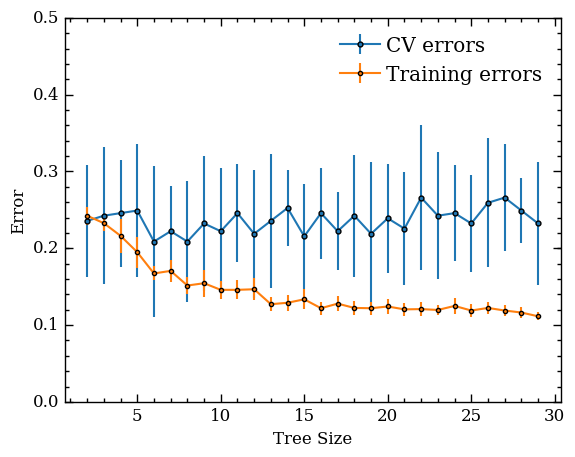

In [482]:
fig, ax = plt.subplots()
ax.errorbar(np.arange(2, 30), test_score, test_score_std, marker='o', ms=3.5, label='CV errors')
ax.errorbar(np.arange(2, 30), train_score, train_score_std, marker='o', ms=3, label='Training errors')
ax.set_ylim([0,0.5])
ax.set_ylabel('Error')
ax.set_xlabel('Tree Size')
ax.legend()
plt.show()

In [483]:
clfCV.best_params_

{'max_leaf_nodes': 6}

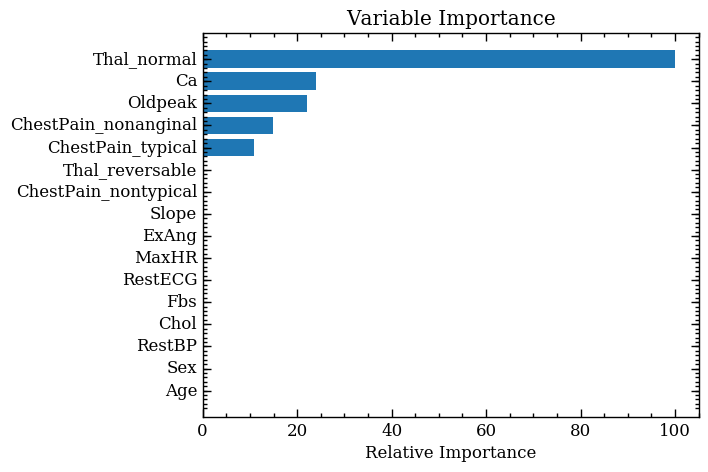

In [450]:
best_clfCV = tree.DecisionTreeRegressor(max_features=9, max_leaf_nodes=6, min_samples_leaf= 5)
best_clfCV.fit(Heart[features], Heart['AHD'])
feature_importance(best_clfCV, features, relative=True)

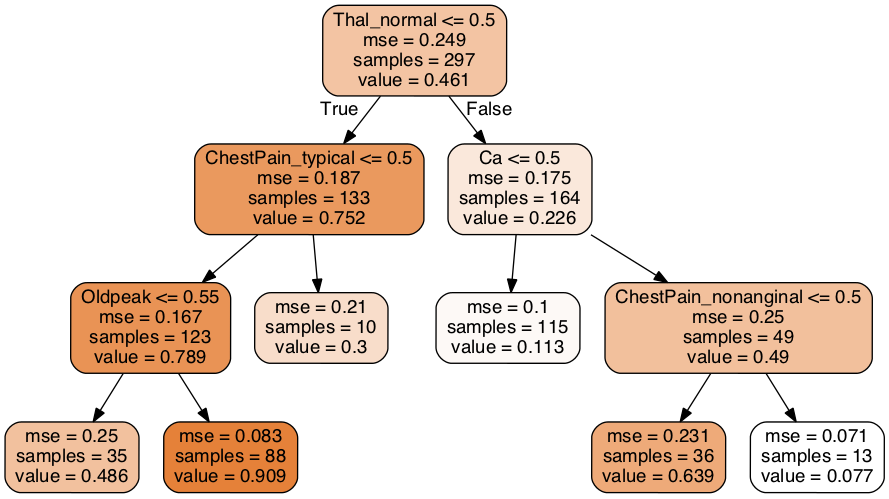

In [663]:
viz_Heart = visualize_tree(best_clfCV, feature_names=features, with_png=True, class_names=['No', 'Yes'], filled=True, rounded=True)
Image(viz_Heart.create_png())

# Bagging and Random forest

In [486]:
param_grid={'n_estimator':np.arange(1, 100)*3.0}

Xtrain, Xtest, ytrain, ytest = train_test_split(Heart[features], Heart['AHD'], test_size=0.5)
# Random Forests
rfbag_oob = []
rfbag_test = []
rf_test = []
rf_oob = []
min_split = 2
maxleaf = 6
#for nest in range(10):
for nest in np.arange(1, 100,2):    
    # Bagging test
    rfbag = RandomForestClassifier(n_estimators=nest, oob_score=False, max_features=1.0, min_samples_split=min_split, max_leaf_nodes=maxleaf)
    rfbag.fit(Xtrain, ytrain)   
    y_pred = rfbag.predict(Xtest)
    rfbag_test.append(1.0 - accuracy_score(ytest, y_pred))
    # OOB test
    rfbag = RandomForestClassifier(n_estimators=nest, oob_score=True, max_features=1.0, min_samples_split=min_split, max_leaf_nodes=maxleaf)
    rfbag.fit(Heart[features], Heart['AHD'])       
    rfbag_oob.append(1.0 - rfbag.oob_score_)
    # random forest test
    rf = RandomForestClassifier(n_estimators=nest, oob_score=False, max_features='sqrt', min_samples_split=min_split, max_leaf_nodes=maxleaf)
    rf.fit(Xtrain, ytrain)
    y_pred = rf.predict(Xtest)
    rf_test.append(1.0 - accuracy_score(ytest, y_pred))
    # OOB test
    rf = RandomForestClassifier(n_estimators=nest, oob_score=True, max_features='sqrt', min_samples_split=min_split,max_leaf_nodes=maxleaf)
    rf.fit(Heart[features], Heart['AHD'])       
    rf_oob.append(1.0 - rf.oob_score_)


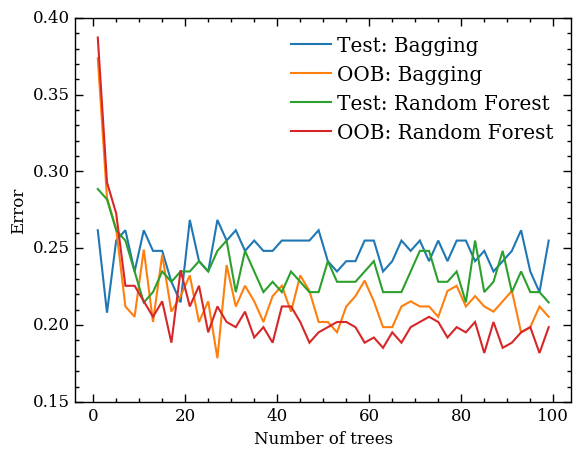

In [487]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, 100,2), rfbag_test, label='Test: Bagging')
ax.plot(np.arange(1, 100,2), rfbag_oob, label='OOB: Bagging')
ax.plot(np.arange(1, 100,2), rf_test, label='Test: Random Forest')
ax.plot(np.arange(1, 100,2), rf_oob, label='OOB: Random Forest')
ax.set_ylim([0.15,0.4])
ax.set_ylabel('Error')
ax.set_xlabel('Number of trees')
ax.legend()
plt.show()

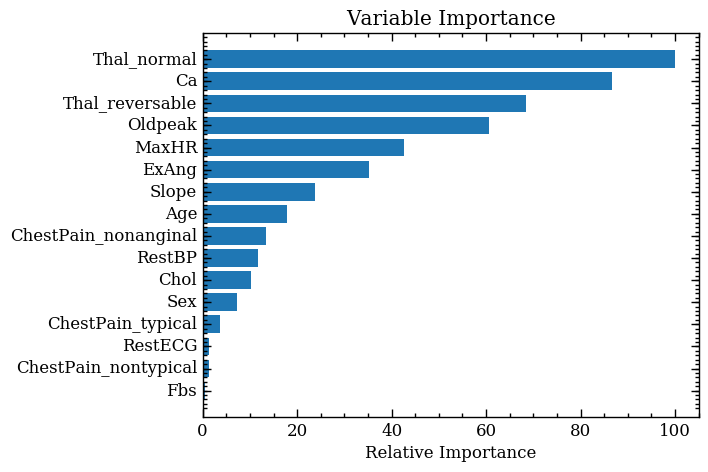

In [490]:
feature_importance(rf, features, relative=True)

# Lab: Decision Tree

In [812]:
Carseats = pd.read_csv('Data/Carseats.csv')
# drop Unnamed: 0 columns
Carseats.drop("Unnamed: 0", axis=1, inplace=True)

In [813]:
Carseats['High'] = Carseats.Sales.apply(lambda x: 1 if x>8 else 0)

In [814]:
#Carseats['ShelveLoc'] = Carseats.ShelveLoc.factorize()[0]
Carseats = pd.get_dummies(Carseats, columns =['ShelveLoc'])
Carseats['Urban'] = Carseats['Urban'].map({'No':0, 'Yes':1})
Carseats['US'] = Carseats['US'].map({'No':0, 'Yes':1})

In [628]:
Carseats.head(2)

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,Urban,US,High,ShelveLoc_Good,ShelveLoc_Medium
0,9.50,138,73,11,276,120,42,17,1,1,1,0,0
1,11.22,111,48,16,260,83,65,10,1,1,1,1,0


In [823]:
def select_feature(df, exclude=None):
    col = df.columns
    for feature in exclude:
        col = col[col != feature]
    return col.values

car_features = select_feature(Carseats, exclude=['Sales', 'High'])
#tree1 = tree.DecisionTreeClassifier(min_samples_leaf=5, max_depth=7)
# To get similar result as R use min_impurity_decrease = 0.005
tree1 = tree.DecisionTreeClassifier(min_samples_leaf=5, min_impurity_decrease = 0.005)
tree1.fit(Carseats[car_features], Carseats['High'])
ypred = tree1.predict(Carseats[car_features])
accuracy_score(Carseats['High'], ypred)

0.89500000000000002

In [821]:
1 - 0.89500000000000002

0.10499999999999998

In [801]:
print_diagtest(Carseats['High'], ypred)

precision: 0.880952380952
recall   : 0.90243902439
fscore   : 0.89156626506
support  : 164
accuracy : 0.91


True,0,1,All
Predicted,,,
0,216,16,232
1,20,148,168
All,236,164,400


In [619]:
print('training_error = {:4.2f}'.format((12+25)/400.0))

training_error = 0.09


In [829]:
thresh = tree1.tree_.threshold
n_leaf = len(thresh[thresh == -2])
print n_leaf

19


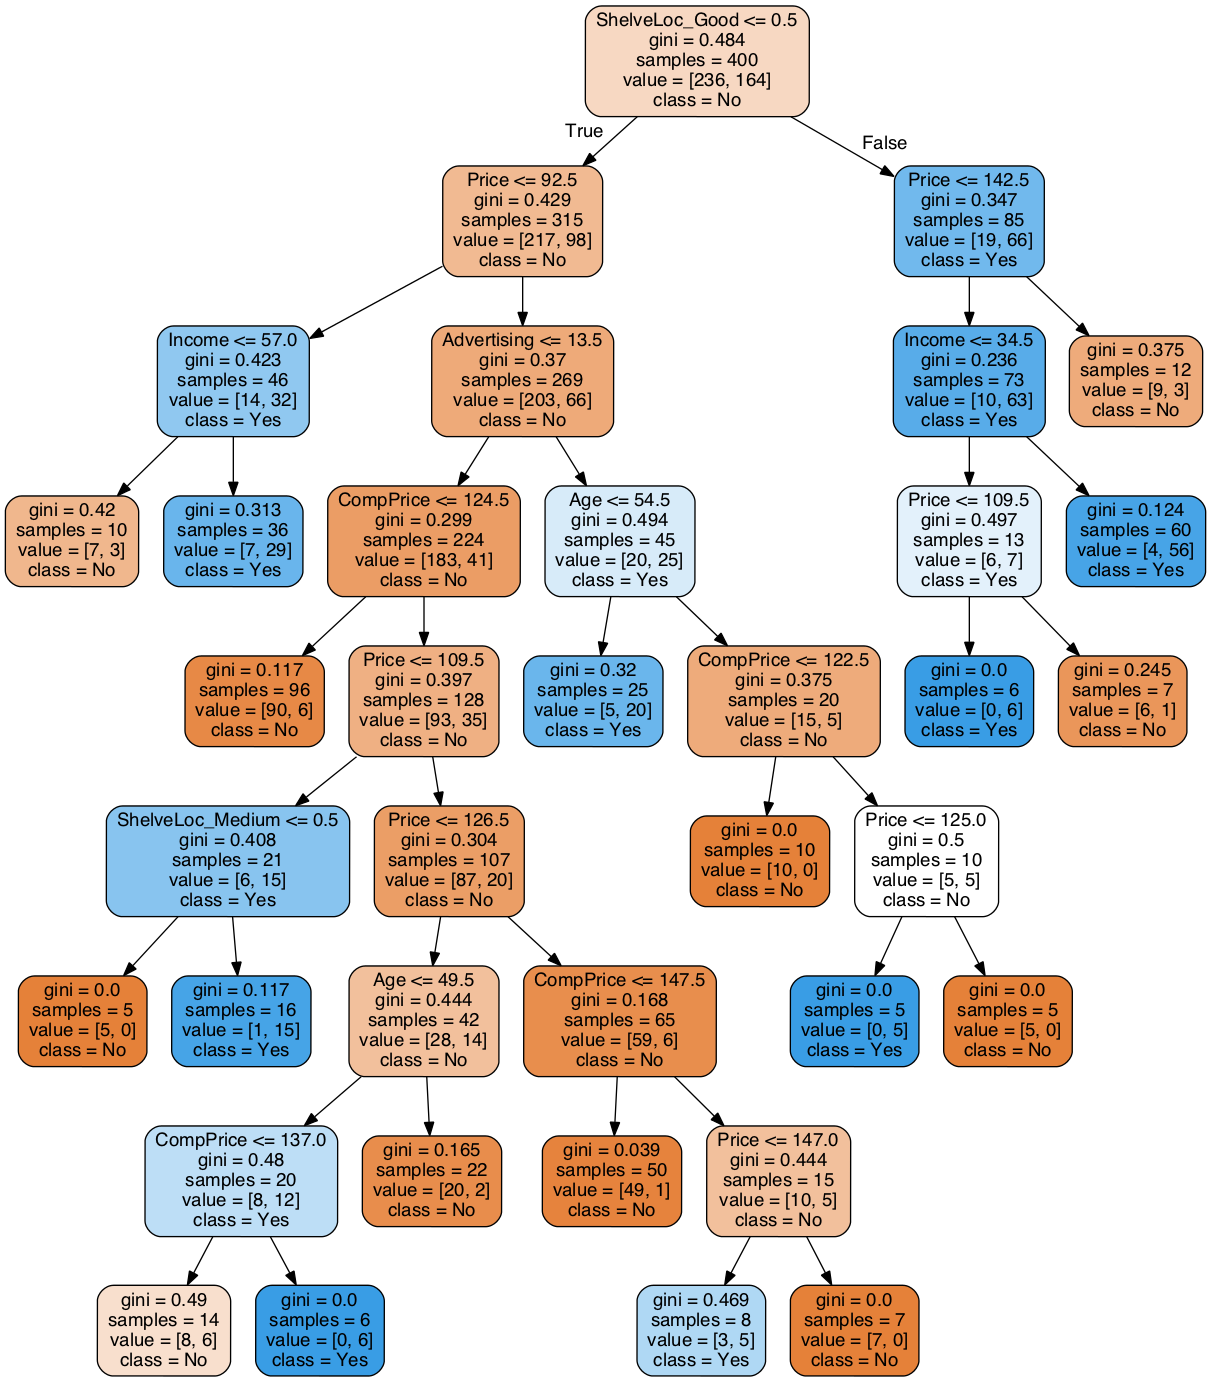

In [824]:
mmm = visualize_tree(tree1, feature_names=car_features, with_png=True, class_names=['No', 'Yes'], filled=True, rounded=True)
#visualize_tree(tree1, feature_names=car_features, class_names=['No', 'Yes'], filled=True, rounded=True)
Image(mmm.create_png())

In [670]:
# Split train and test sample
Xtrain, Xtest, ytrain, ytest = train_test_split(Carseats[car_features], Carseats['High'], test_size=0.5)

# Run Decision tree on Train data
tree2 = tree.DecisionTreeClassifier(min_samples_leaf=5, max_depth=7)
tree2.fit(Xtrain, ytrain)

# predict test data and compute accuracy
ypred = tree2.predict(Xtest)
accuracy = accuracy_score(ytest, ypred)
print('Test error = {:4.2f}'.format(accuracy))

Test error = 0.80


In [671]:
print_diagtest(ytest, ypred)

precision: 0.708860759494
recall   : 0.756756756757
fscore   : 0.732026143791
support  : 74
accuracy : 0.795


True,0,1,All
Predicted,,,
0,103,18,121
1,23,56,79
All,126,74,200


## Fitting Regression Tree

In [830]:
Boston = pd.read_csv('Data/Boston.csv')
Boston_features = select_feature(Boston, exclude=['medv'])
X_scaled = scaler.fit_transform(Boston[Boston_features])
Xtrain, Xtest, ytrain, ytest = train_test_split(X_scaled, Boston['medv'], test_size=0.5)


In [841]:
# Run Decision tree on Train data
tree3 = tree.DecisionTreeRegressor(min_samples_leaf = 5, max_depth=3, min_impurity_decrease = 0.005)
#, min_impurity_decrease=0.5)
tree3.fit(Xtrain, ytrain)

# compute accuracy
ypred = tree3.predict(Xtrain)
#accuracy = mean_squared_error(ytrain, ypred)
accuracy = tree3.score(Xtrain, ytrain)
print('Test error = {:4.2f}'.format(accuracy))

Test error = 0.79


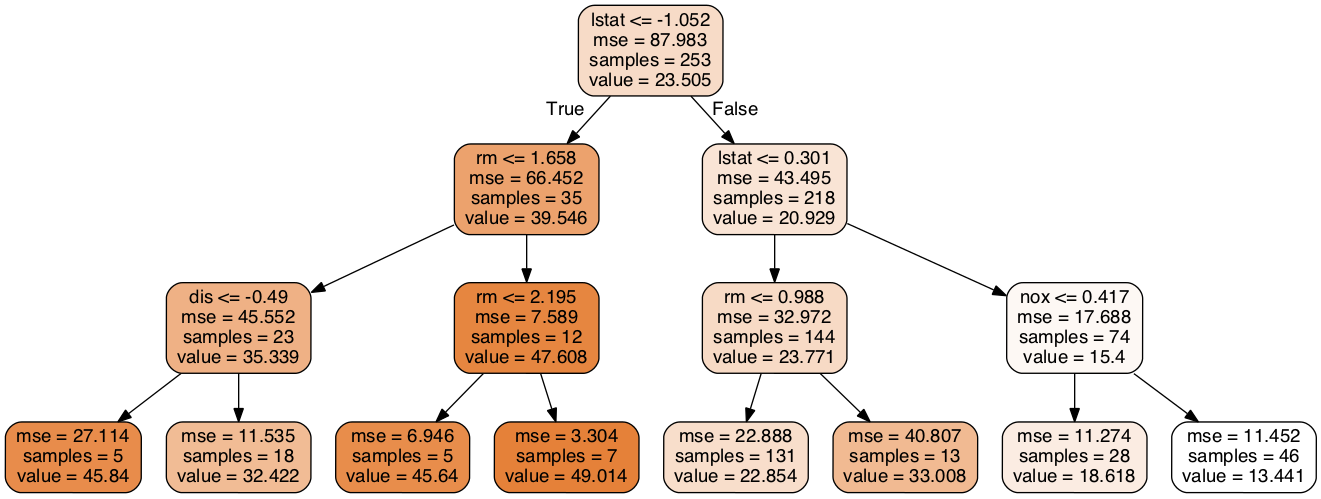

In [842]:
mmm = visualize_tree(tree3, with_png=True, feature_names=Boston_features, filled=True, rounded=True)
Image(mmm.create_png())

### Cross-validation 

In [867]:
tree_sizes = range(2, 31)

MSE_scores = []

# 5-Fold CV for each tree size 
for size in tree_sizes:
    clf_tree = tree.DecisionTreeRegressor(max_leaf_nodes=size, random_state=0, min_impurity_decrease=0.005)
    mse = cross_val_score(clf_tree, X_scaled, Boston['medv'], cv=10, scoring='neg_mean_squared_error')
    MSE_scores.append(mse.mean())
   

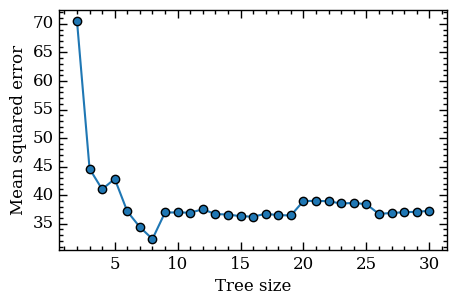

In [903]:
fig, ax1 = plt.subplots(figsize=(5,3))
ax1.plot(np.asarray(tree_sizes), -np.asarray(MSE_scores), 'o-')
ax1.set_xlabel('Tree size')
ax1.set_ylabel('Mean squared error')
plt.show()

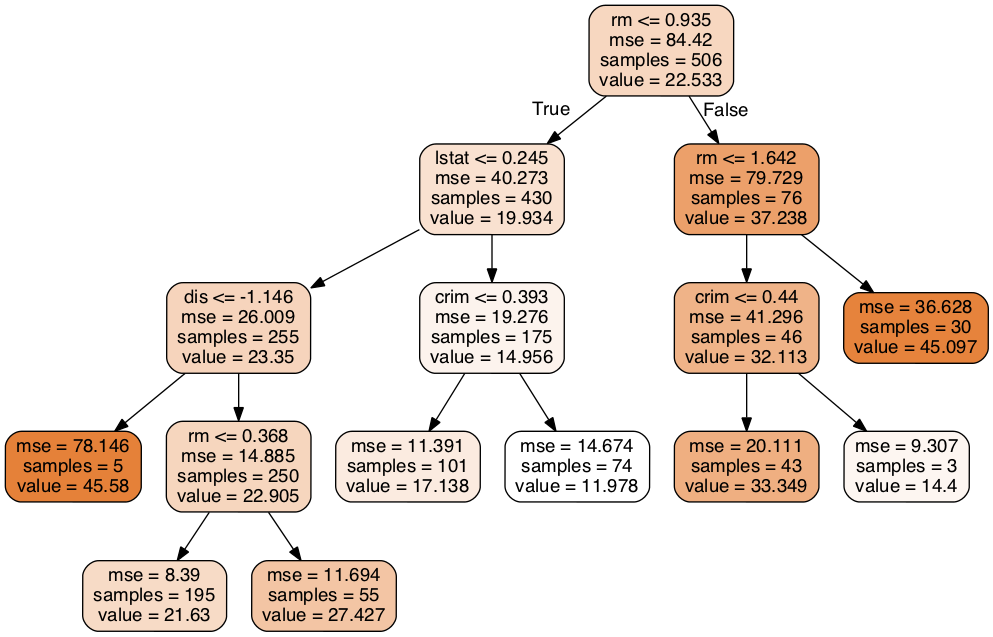

In [869]:
clf_tree = tree.DecisionTreeRegressor(max_leaf_nodes=8, random_state=0, min_impurity_decrease=0.005)
clf_tree.fit(X_scaled, Boston['medv'])
mmm = visualize_tree(clf_tree, with_png=True, feature_names=Boston_features, filled=True, rounded=True)
Image(mmm.create_png())

## Bagging and Random Forests

In [889]:
# Bagging is a Random forest using all predictors at each split (m=p)
rf1 = RandomForestRegressor(n_estimators = 500, max_leaf_nodes=8, max_features=None, random_state=0, min_impurity_decrease=0.005)
rf1.fit(Xtrain, ytrain)
ypred = rf1.predict(Xtest)
mean_squared_error(ytest, ypred)

13.837390091037475

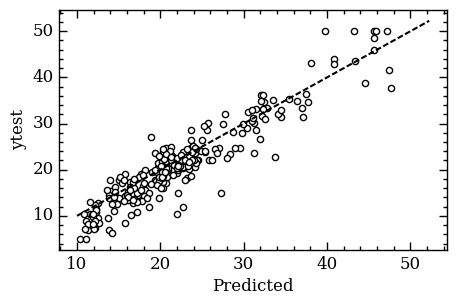

In [904]:
fig, ax1 = plt.subplots(figsize=(5,3))
ax1.scatter(ypred, ytest, facecolors='w', edgecolors='k' )
ax1.plot([10,ax1.get_ylim()[1]],[10,ax1.get_ylim()[1]], '--k')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('ytest')
plt.show()

In [892]:
np.mean((ypred-ytest)**2)

13.837390091037477

In [915]:
# Random Forest using 6 predictors at each split
rf1 = RandomForestRegressor(n_estimators = 500, max_leaf_nodes=20, max_features=6, random_state=0, min_impurity_decrease=0.005)
rf1.fit(Xtrain, ytrain)
ypred = rf1.predict(Xtest)
mean_squared_error(ytest, ypred)


11.223448721479722

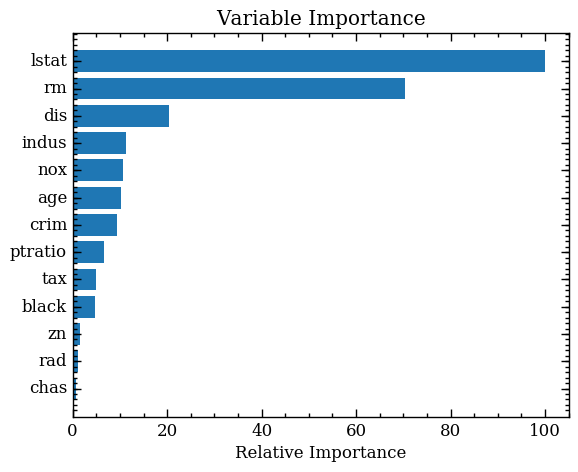

In [900]:
feature_importance(rf1, Boston_features, relative=True)

### Boosting

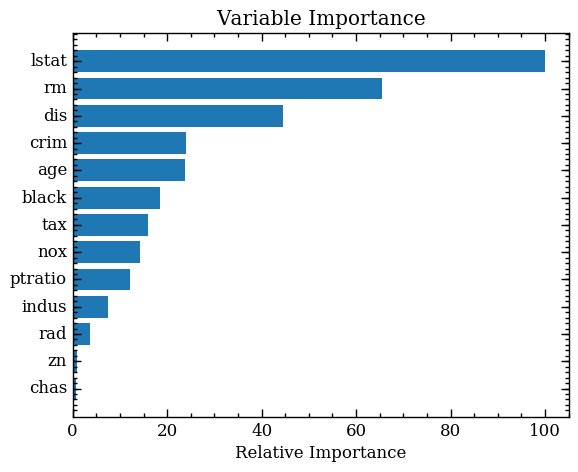

In [925]:
boost = GradientBoostingRegressor(n_estimators=1000, max_depth=5, learning_rate=0.005, min_impurity_decrease=0.05, random_state=0)
boost.fit(Xtrain, ytrain)
feature_importance(boost, Boston_features, relative=True)

In [2]:
boost

NameError: name 'boost' is not defined